In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import scorecardpy as scp
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
import numpy as np
from sklearn.model_selection import train_test_split 

In [188]:
df = pd.read_csv('telecom_churn.csv')
# Преобразуем целевую переменную к типу int:
df['Churn'] = df['Churn'].apply(int)
# и аналогично две другие:
df['International plan'] = pd.get_dummies(df['International plan']).Yes # Yes = 1, No = 0
df['Voice mail plan'] = pd.get_dummies(df['Voice mail plan']).Yes # Yes = 1, No = 0
# Сделаем из переменной "State" целочисленную:
df = df.merge(pd.Series(df.State.unique()).reset_index().rename({0:'State'}, axis=1), on='State', how='left')\
.drop('State', axis=1).rename({'index':'State'}, axis=1)
# Перекиним столбец "State" в начало:
df = df[['State'] + [col for col in df.columns if col != 'State']]
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,1,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,3,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,20,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,8,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,10,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,49,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


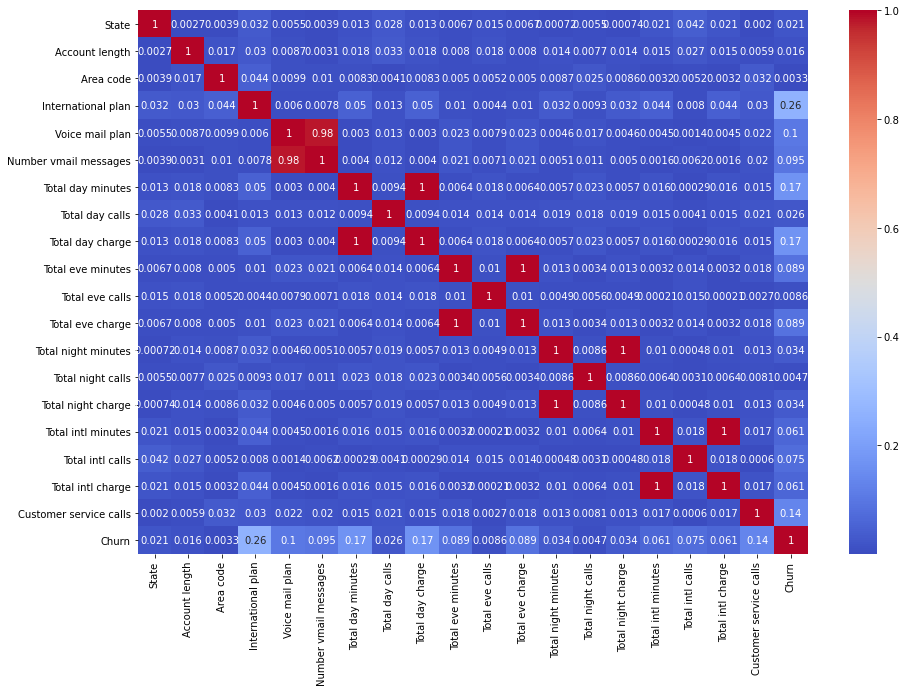

In [189]:
# построим матрицу корреляций, чтобы сразу исключить ненужные переменные
def corr_matrix(df):
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df.corr('spearman').abs(), annot=True, cmap='coolwarm')
corr_matrix(df)

In [64]:
# выкинем из выборки 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Number vmail messages'
# потому что они сильно коррелируют с другими переменными

df = df[[el for el in df.columns if el not in
         ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Number vmail messages']]]

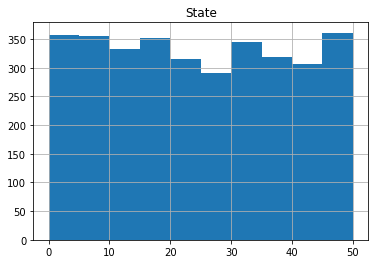

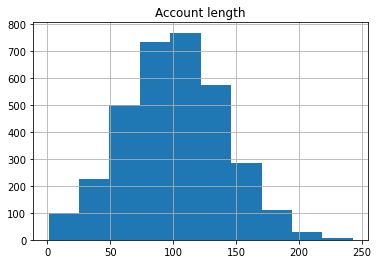

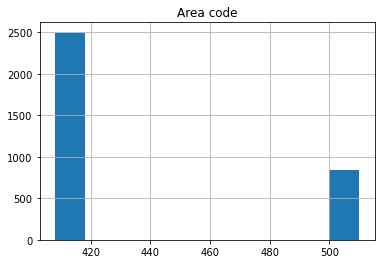

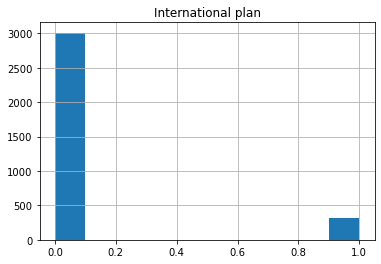

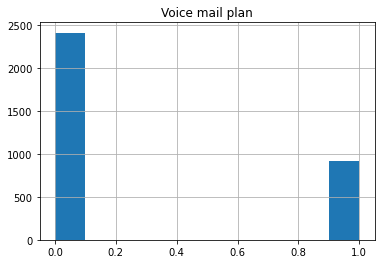

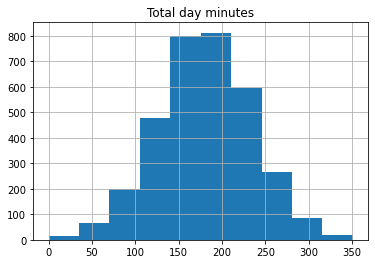

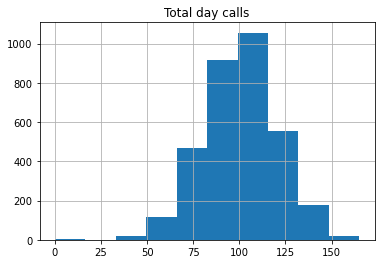

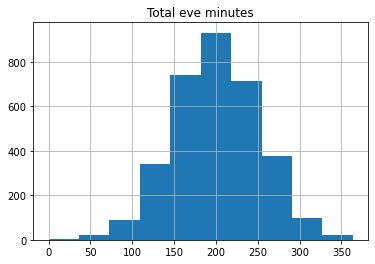

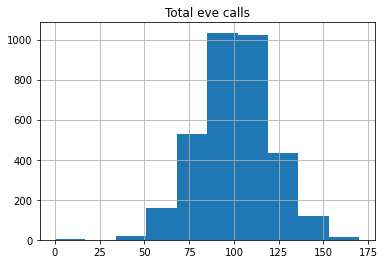

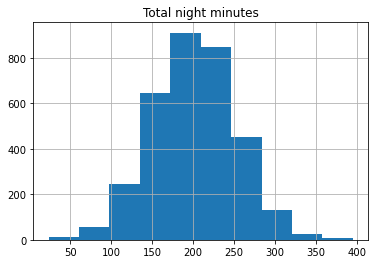

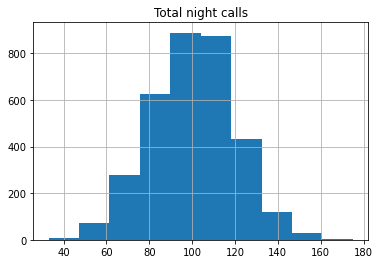

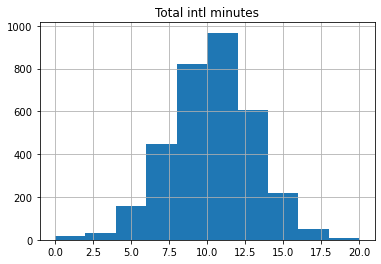

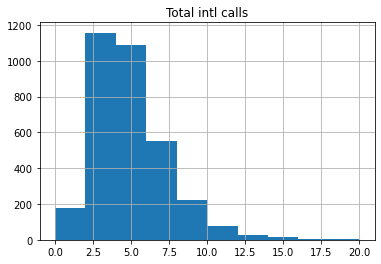

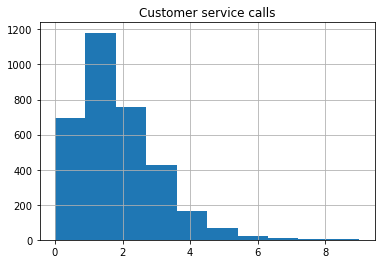

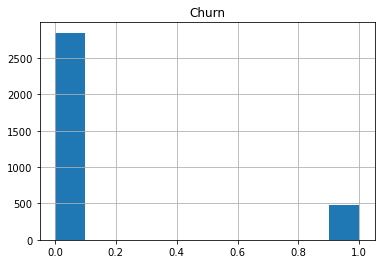

In [65]:
# Посмотрим на распределение каждой переменной:
for col in df.columns:
    df[col].hist()
    plt.title(col)
    plt.show()

In [66]:
# делим на тренировочную и тестовую выборки
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## Измерим индекс Джини (roc-auc) и Recall модели лог. регрессии с кросс-валидацией:

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

In [186]:
pipe = Pipeline([('scaler', StandardScaler()), ('PolyFeaturizer', PolynomialFeatures(degree=3)),
                 ('regression', LogisticRegressionCV(n_jobs=-1, Cs=[i for i in np.logspace(-2, 2, 10)], 
                                                     cv=5, scoring='accuracy'))])
pipe.fit(X_train, y_train)
print("Accuracy = %.3f, Recall = %.3f" % (accuracy_score(y_test, pipe.predict(X_test)), 
                      recall_score(y_test, pipe.predict(X_test))))

Accuracy = 0.915, Recall = 0.528


In [ ]:
## Теперь посмотрим как справится решеющий лес:

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [180]:
forest_params = {'n_estimators':[i for i in range(10, 50)], 'min_samples_leaf':[i for i in range(1, 10)]}
forest = GridSearchCV(estimator=RandomForestClassifier(n_estimators=10, random_state=42, criterion='gini'), 
                      cv=5, param_grid=forest_params)
forest.fit(X_train, y_train)

print("Accuracy = %.3f, Recall = %.3f" % (accuracy_score(y_test, forest.predict(X_test)), 
                      recall_score(y_test, forest.predict(X_test))))

Accuracy = 0.936, Recall = 0.600


In [187]:
# RandomForest справился лучше регрессии.